In [1]:
import matplotlib as mpl
from Datasets import * 
import os

import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(precision=3, linewidth=120)
from LiteModels import DeepLite
from Datasets import *

from MMD.mmd import MMD_3_Sample_Test
import h5py as h5
from tqdm import trange
from scipy.misc import imresize
import seaborn as sns
import pandas as pd

from nuts import nuts
from nuts.emcee_nuts import NUTSSampler
from maf import experiments as ex

from KCEF.estimators.kcef import KCEF_Gaussian
from Datasets import *
from KCEF.tools import median_heuristic
from Utils import get_grid


%matplotlib inline

Using cuDNN version 6021 on context None
Mapped name None to device cuda: GeForce GTX 1080 Ti (0000:84:00.0)


In [2]:
n_hiddens = 30
n_layers = 5
n_comps = 10

act_fun = 'tanh'
mode = 'random'

N = 10000
seed = 12
niter = 10000
ntrain = 100
nvalid = 100
npoint = 200
patience =30
nlayer = 3

idx_i, idx_j = 0,1

ngrid = 100
eval_grid = np.linspace(-8,8,ngrid)

cond_values = np.zeros(2)
eval_points = get_grid(eval_grid, idx_i, idx_j, cond_values)

NameError: name 'adf' is not defined

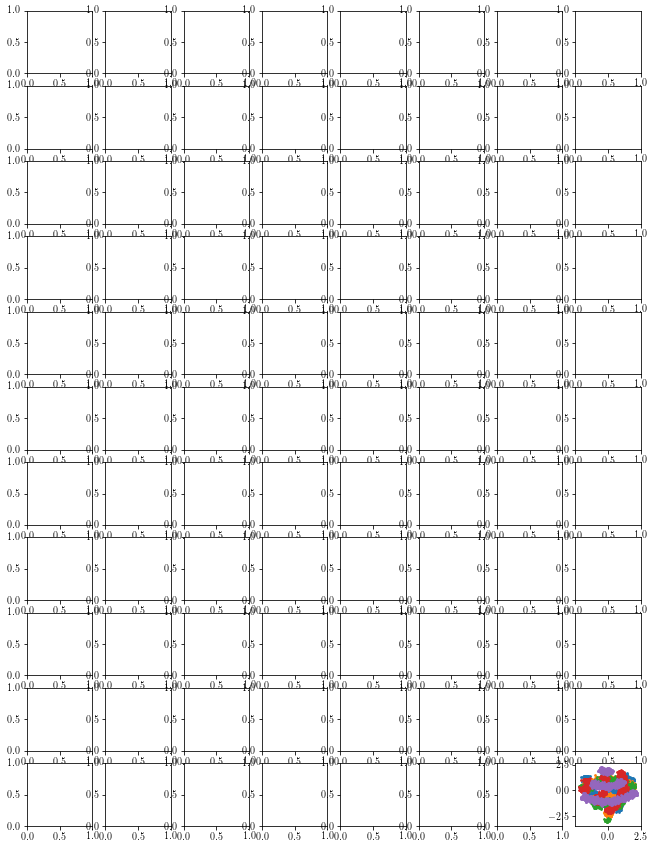

In [22]:
from matplotlib import rc
rc('text', usetex=True)

fig, axes = plt.subplots(11, 8, figsize=(11,15))

others_list =["MADE", "MADE_MOG","MAF", "MAF_MOG", "NVP"]
others_display_names= dict(MADE="MADE", MADE_MOG="MADE-MOG", MAF="MAF", MAF_MOG="MAF-MOG", NVP="NVP")

idx_i, idx_j=0,1
grid_points = get_grid(np.linspace(-5,5,4), idx_i,idx_j,np.zeros(2))

grid_data_one=np.linspace(-8,8,100)
grid_data   = get_grid(grid_data_one, idx_i,idx_j,np.zeros(2))

def plot_logpdf(ax, pdf):
    pdf -= pdf.max()
    ngrid = int(np.sqrt(pdf.shape[0]))
    pcolor = ax.pcolor(eval_grid, eval_grid, pdf.reshape(ngrid, ngrid), vmin=-9)
    pcolor.set_edgecolor('face')
    ax.set_xlim(grid_data_one.min(),grid_data_one.max())
    ax.set_ylim(grid_data_one.min(),grid_data_one.max())
    ax.set_yticks([-5,0,5])
    ax.set_aspect("equal", "box")
    ax.set_axis_off()
    return pcolor


model_name_properties = dict(rotation=90,va="center", ha="right")

dnames = ["Funnel", "Banana","Ring","Uniform", "Cosine","Grid", "Multiring", "Multiring_mix"]
dnames = [ "Multiring_mix"]



for di, dname in enumerate(dnames):
#for di, dname in enumerate(["Uniform"]):

    scores = []
    logliks = []
    ax = axes[0, di]
    this_p = load_data(dname.split("_")[0], D=2,N=N, seed=seed, rotate=dname in ["Funnel", "Banana", "Cosine", "Uniform", "Door"])
    
    if "mix" not in dname:
        
        real_pdf = this_p.logpdf_multiple(eval_points)
        plot_logpdf(ax, real_pdf)
        real_loglik = this_p.logpdf_multiple(this_p.test_data).mean()
        if di == 0:
            ax.text(-0.1,0.5,"truth", transform=ax.transAxes,  **model_name_properties)
        ax.set_title("%.2f" % real_loglik)
        #ax.scatter(p.test_data[:,0], p.test_data[:,1], 2,"r", alpha=0.1)
    else:
        p_m = Mixture(this_p,5,12)
        for i in range(5):
            data = p_m.ps[i].data
            plt.scatter(data[:,0], data[:,1], 3)
    adf
        
    saved_pdf = np.load("figs/others_%s_data.npz" % dname)
    for mi, mname in enumerate(others_list):
        ax = axes[mi+1, di]
        pdf = saved_pdf[mname.lower()+"_pdf"]
        plot_logpdf(ax, pdf)
        loglik = saved_pdf[mname.lower()+"_loglik"]
        score  = saved_pdf[mname.lower()+"_score"]
        
        if di == 0:
            ax.text(-0.1,0.5, others_display_names[mname],  transform=ax.transAxes, **model_name_properties)
        if not np.isnan(score):
            ax.set_title("%.2f,%.2g"%(loglik.mean(), score))
        else:
            ax.set_title("%.2f, N/A"%(model_loglik))   
        scores += score,
        logliks += loglik,
    
    
    fn = "figs/kcef_%s_data.npz" % dname
    if os.path.isfile(fn):
        
        saved_pdf = np.load("figs/kcef_%s_data.npz" % dname)
        ax = axes[6, di]
        pdf = saved_pdf["logpdf"]
        plot_logpdf(ax, pdf)
        kcef_loglik = saved_pdf["loglik"]
        kcef_score  = saved_pdf["score"]

        scores += kcef_score,
        logliks += kcef_loglik,

        if di == 0:
            ax.text(-0.1,0.5, "KCEF", transform=ax.transAxes, **model_name_properties)
        if not np.isnan(kcef_score):
            ax.set_title("%.2f,%.2g"%(kcef_loglik, kcef_score))
        else:
            ax.set_title("%.2f, N/A"%(kcef_loglik))    
    
    lite_names = [ "sl_model", "dl_model", "ll_model", "kl_model"]
    #lite_names = [ "dl_model"]

    lite_display_names = [ "KEF-G", "DKEF-G-15", "DKEF-L-50", "DKEF-L-50-1"]
    for li, ln in enumerate(lite_names):
        ax = axes[ 7+li, di]
        saved_pdf = np.load("figs/%s_%s_data.npz" % (ln, dname))
        if ln != "ll_model" and dname != "Multiring_mix":
            kernel_vals = saved_pdf["kernel_vals"]
            grid_points = saved_pdf["grid_points"]
            kvs = kernel_vals
            for i in range(kvs.shape[0]):
                kv = kvs[i]
                ax.contour(grid_data_one, grid_data_one, kv.reshape(100,100), [0.9], vmin=kv.min(), vmax=kv.max(), colors="C%d"%(i%9), linewidths=[2], alpha=.5)
                #ax.plot(grid_points[i,idx_i], grid_points[i,idx_j], ".",  color="C%d"%(i%9), alpha=0.5)
                
        pdf = saved_pdf["logpdf"]
        im = plot_logpdf(ax, pdf)
        model_loglik = saved_pdf["after_loglik"]
        model_score = saved_pdf["after_score"]
        if di == 0:
            ax.text(-0.1,0.5, lite_display_names[li],  transform=ax.transAxes, **model_name_properties)
        if not np.isnan(model_score):
            ax.set_title("%.2f,%.2g"%(model_loglik, model_score))
        else:
            ax.set_title("%.2f, N/A"%(model_loglik))    
        
        scores += model_score,
        logliks += model_loglik,
        
    ll_max = np.argmax(logliks)+1
    title_str = axes[ll_max,di].get_title()
    ll_str, sc_str = title_str.split(",")
    axes[ll_max,di].set_title(r"\textbf{%s}"%ll_str + ",%s"%sc_str)
    
    sc_min = np.argmin(scores)+1
    title_str = axes[sc_min,di].get_title()
    ll_str, sc_str = title_str.split(",")
    axes[sc_min,di].set_title(ll_str + r",\textbf{%s}"%sc_str)


plt.tight_layout(h_pad=-1, w_pad=-5)
fig.subplots_adjust(right=0.96)
cbar_ax = fig.add_axes([0.94, 0.03, 0.01, 0.3])
fig.colorbar(im, cax=cbar_ax)
#plt.colorbar()
#fig.savefig("figs/toys.png", dpi=200)

array(5.353579255284976)